In [1]:
import time, datetime, psutil

from Source.metalayer import *
from Source.plotting import *
from Source.training import *
from Source.load_data import *

import warnings
import pickle

CUDA Available


In [2]:
# global seed function for reproducibility 
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.banchmark = False

In [3]:
# Load hyperparameters
fname = "best_hparams.pkl"
with open(fname, 'rb') as file:
    best_hparams = pickle.load(file)

# Print hparams
print('\nBest hyperparameters:')
print(f'\tlearnig_rate: {best_hparams.learning_rate:.3e}')
print(f'\tT_max: {best_hparams.T_max}')
print(f'\tweight_decay: {best_hparams.weight_decay:.3e}')
print('\tn_layers: {}'.format(best_hparams.n_layers))
print('\thidden_channels: {}'.format(best_hparams.hidden_channels))


Best hyperparameters:
	learnig_rate: 8.642e-04
	T_max: 19
	weight_decay: 2.144e-06
	n_layers: 2
	hidden_channels: 8


In [4]:
# setting epochs

# best_hparams.learning_rate = 0.000762
# best_hparams.T_max = 30
# best_hparams.weight_decay = 1e-8
best_hparams.n_epochs = 400

In [5]:
set_seed(12)
time_ini = time.time()
warnings.filterwarnings("ignore")

# Load data and create dataset
print('\n--- Creating dataset ---\n')
time_dataset = time.time()
dataset = create_dataset(best_hparams)
print("Dataset created. Time elapsed:", datetime.timedelta(seconds=time.time()-time_dataset))

# Number of input node features (1, mass)
node_features = dataset[0].x.shape[1]


--- Creating dataset ---



In [ ]:
# Split dataset among training, validation and testing datasets
set_seed(12)
train_loader, valid_loader, test_loader = split_datasets(dataset)

# Size of the output of the GNN 
dim_out = 2 * best_hparams.pred_params # in our case is 2 as mean and variance

# Initialize model
model = GNN(node_features=node_features,
            n_layers=best_hparams.n_layers,
            hidden_channels=best_hparams.hidden_channels,
            linkradius=best_hparams.r_link,
            dim_out=dim_out)

model.to(device)

process = psutil.Process()
print(f"Memory being used (GB): {process.memory_info().rss/1.e9:.3f}")

Memory being used (GB): 1.434


In [ ]:
# Train the net
set_seed(12)
print("\n--- Training ---\n")
train_losses, valid_losses, test_losses = training_routine(model, train_loader, valid_loader, test_loader, best_hparams, verbose=True)


--- Training ---

Validation loss decreased (1.00e+03 --> -5.66e+00).  Saving model ...
Epoch: 001, Train Loss: 8.61e+00, Validation Loss: -5.66e+00, Error: 6.61e+00
Validation loss decreased (-5.66e+00 --> -6.06e+00).  Saving model ...
Epoch: 002, Train Loss: -6.24e+00, Validation Loss: -6.06e+00, Error: 8.54e+00
Validation loss decreased (-6.06e+00 --> -6.27e+00).  Saving model ...
Epoch: 003, Train Loss: -6.37e+00, Validation Loss: -6.27e+00, Error: 7.27e+00
Validation loss decreased (-6.27e+00 --> -6.36e+00).  Saving model ...
Epoch: 004, Train Loss: -6.61e+00, Validation Loss: -6.36e+00, Error: 7.92e+00
Validation loss decreased (-6.36e+00 --> -6.43e+00).  Saving model ...
Epoch: 005, Train Loss: -6.62e+00, Validation Loss: -6.43e+00, Error: 7.22e+00
Validation loss decreased (-6.43e+00 --> -6.58e+00).  Saving model ...
Epoch: 006, Train Loss: -6.74e+00, Validation Loss: -6.58e+00, Error: 7.61e+00
Validation loss decreased (-6.58e+00 --> -6.63e+00).  Saving model ...
Epoch: 007, 

In [ ]:
# Test the model
set_seed(12)
test_loss, rel_err, chi2 = test(test_loader, model, best_hparams)
print("Test Loss: {:.4f}, Relative error: {:.4f}, Chi2: {:.4f}".format(test_loss, rel_err, chi2))

Test Loss: -14.2058, Relative error: 0.5817, Chi2: 17.5367


In [ ]:
print("Finished. Time elapsed:",datetime.timedelta(seconds=time.time()-time_ini))

Finished. Time elapsed: 0:21:03.690210


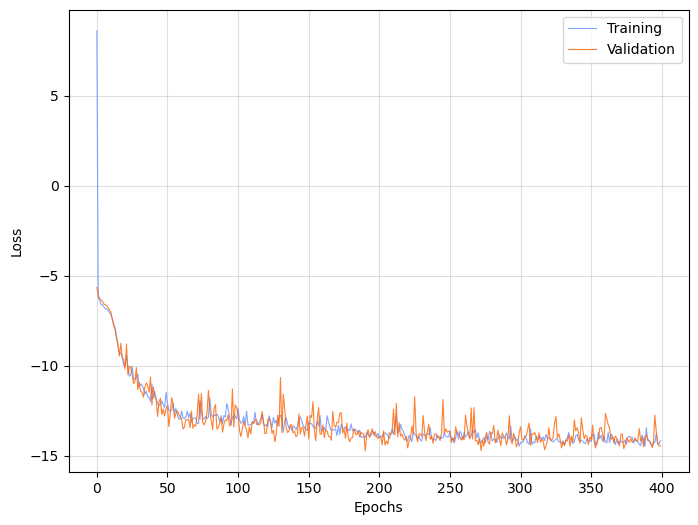

In [ ]:
# Plot loss trends
plot_losses(train_losses, valid_losses, best_hparams, display = True)

R2: 0.908
relative error: 0.101
A fraction of succeses of 0.548 at 1 sigma, 0.882 at 2 sigmas


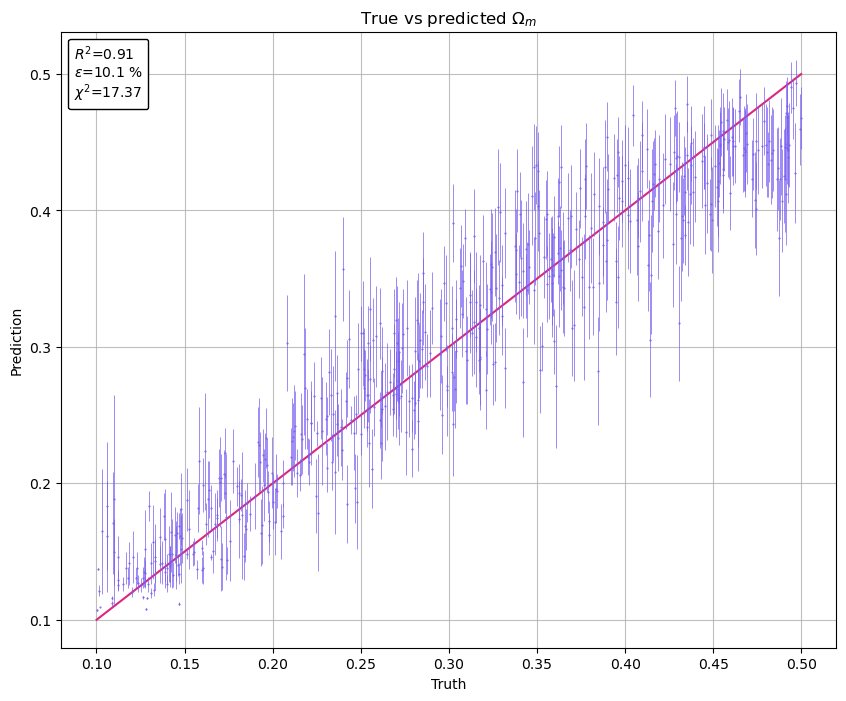

In [ ]:
# Plot true vs predicted params
plot_out_true_scatter(best_hparams, "Om", display = True)
if best_hparams.pred_params==2:
    plot_out_true_scatter(best_hparams, "Sig", display = True)